In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams['savefig.dpi'] = 100
rcParams['figure.dpi'] = 100
rcParams["font.size"] = 20

Text(0, 0.5, 'y')

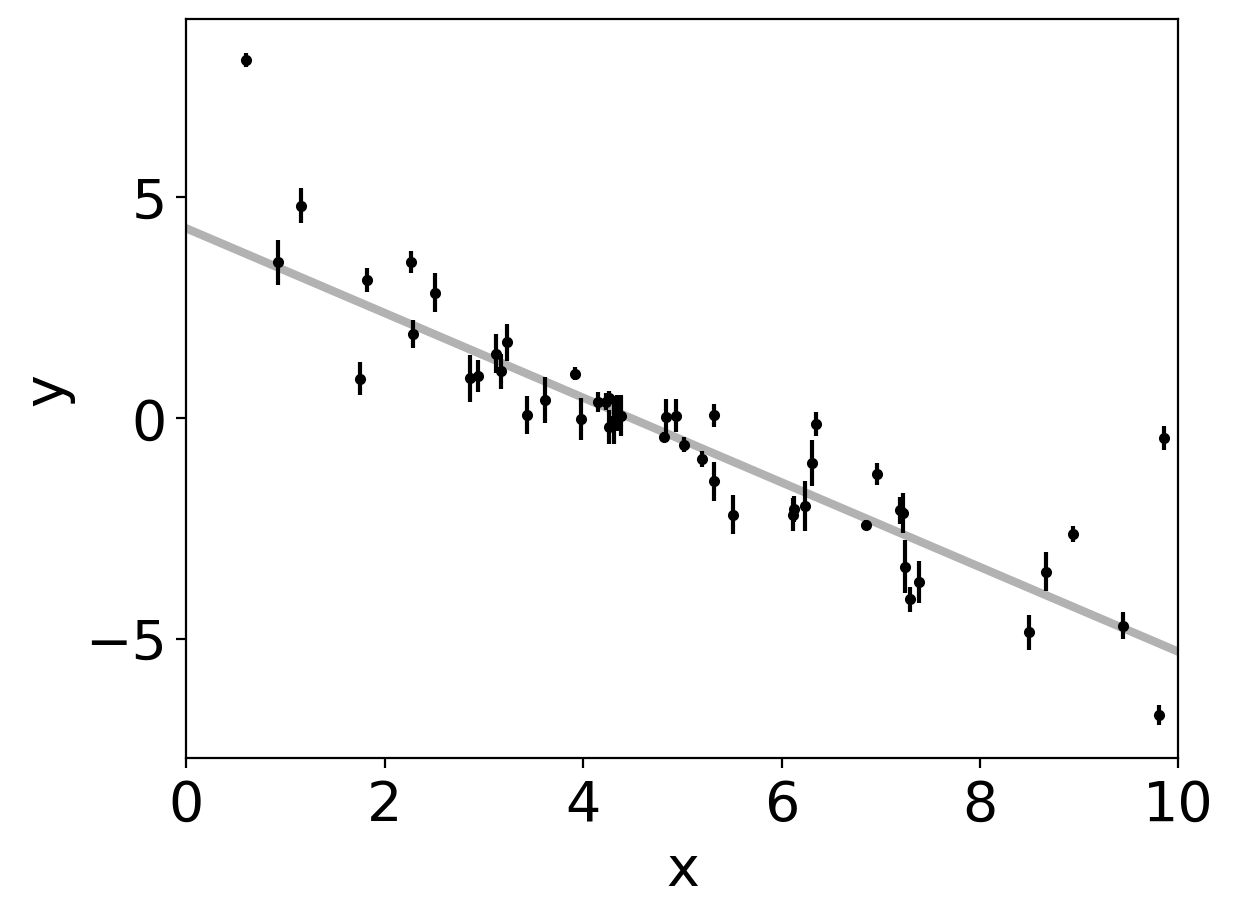

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

#Parâmetros VERDADEIROS
m_true = -0.9594 # Coeficiente angular negativo... logo decrescente
b_true = 4.294
f_true = 0.534

#Agora, a partir do modelo, preciso gerar dados
N = 50
x = np.sort(10*np.random.rand(N)) # poderia colocar x = np.sort(10*random.rand(50)) obviamente, mas vou preserevar o formalismo do tutorial e manter esse N.
yerr = 0.1 + 0.5*np.random.rand(N)
y = m_true * x + b_true #Equação da reta - Seria aqui que eu coloco o modelo?
y += np.abs(f_true*y)*np.random.randn(N) #Qual a diferença entre rand e randn
y += yerr*np.random.randn(N)

plt.errorbar(x,y, yerr=yerr, fmt = '.k', capsize = 0)
x0 = np.linspace(0,10, 500) #construção do eixo x
plt.plot(x0, m_true*x0 + b_true, 'k', alpha = 0.3, lw = 3)
plt.xlim(0,10)
plt.xlabel('x')
plt.ylabel('y')


Estimativa de Míniimos Quadrados
m= -1.032 ± 0.046
b= 4.973 ± 0.259


Text(0, 0.5, 'y')

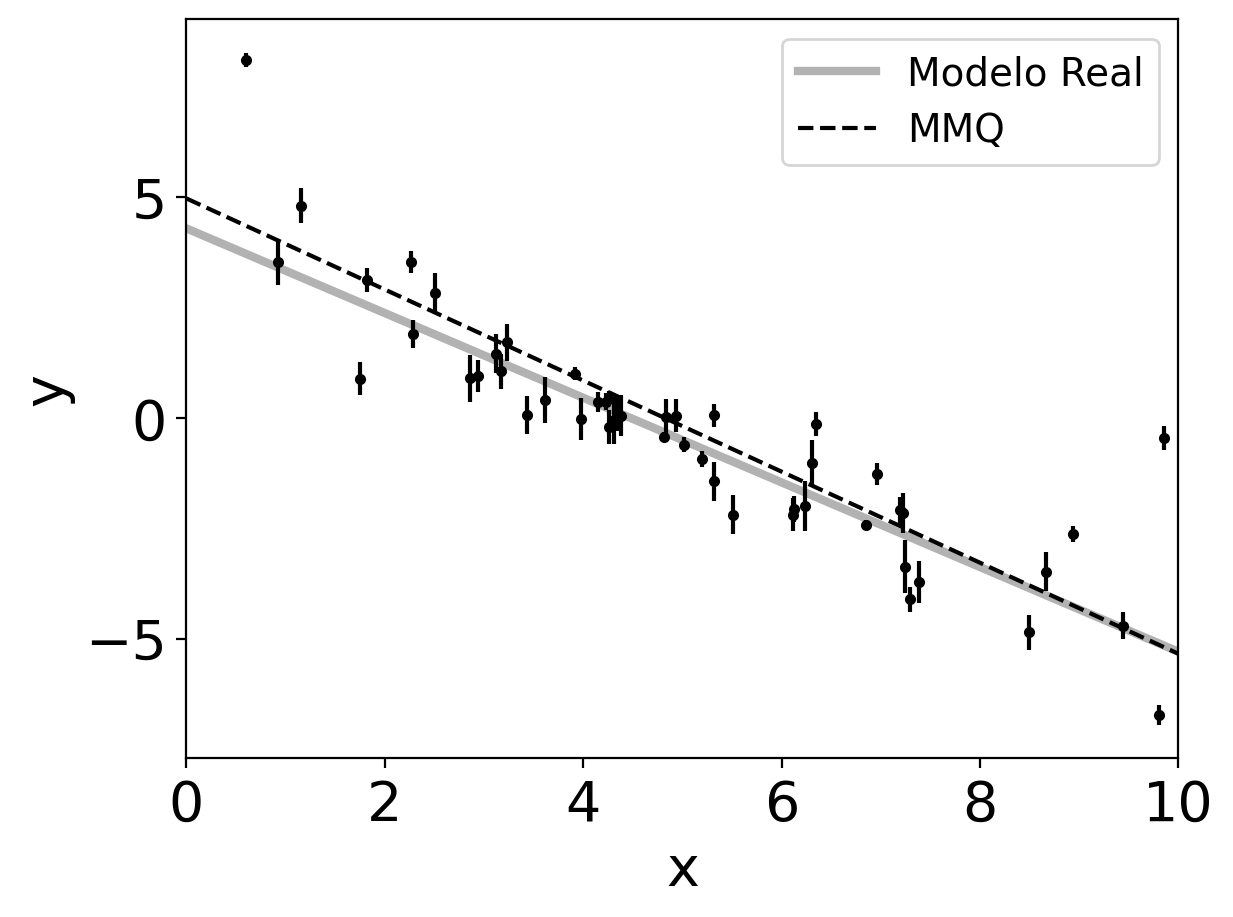

In [3]:
#Agora, vamos resolver o mínimos quadrados para os dados acima

# "Matrizes"
A = np.vander(x, 2) #Qual a função desse 2?
C = np.diag(yerr*yerr)

#Produto de matrizes
ATA = np.dot(A.T, A/(yerr*2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y/(yerr*2))) #Tipo array
print('Estimativa de Míniimos Quadrados')
print("m= {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0,0])))
print("b= {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1,1]))) #Os dados os Mínimos Quadrados estão nas diagonais

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="Modelo Real")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="MMQ")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [4]:
#Agora definindo a Loglikelihood

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta #Variáveis de Parâmetros
    model = m * x + b #Variável de modelo
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) #ln p(y|x, sigma, m, b, f)

Máxima Verossimilhança
m = -1.003
b = 4.528
f = 0.454


Text(0, 0.5, 'y')

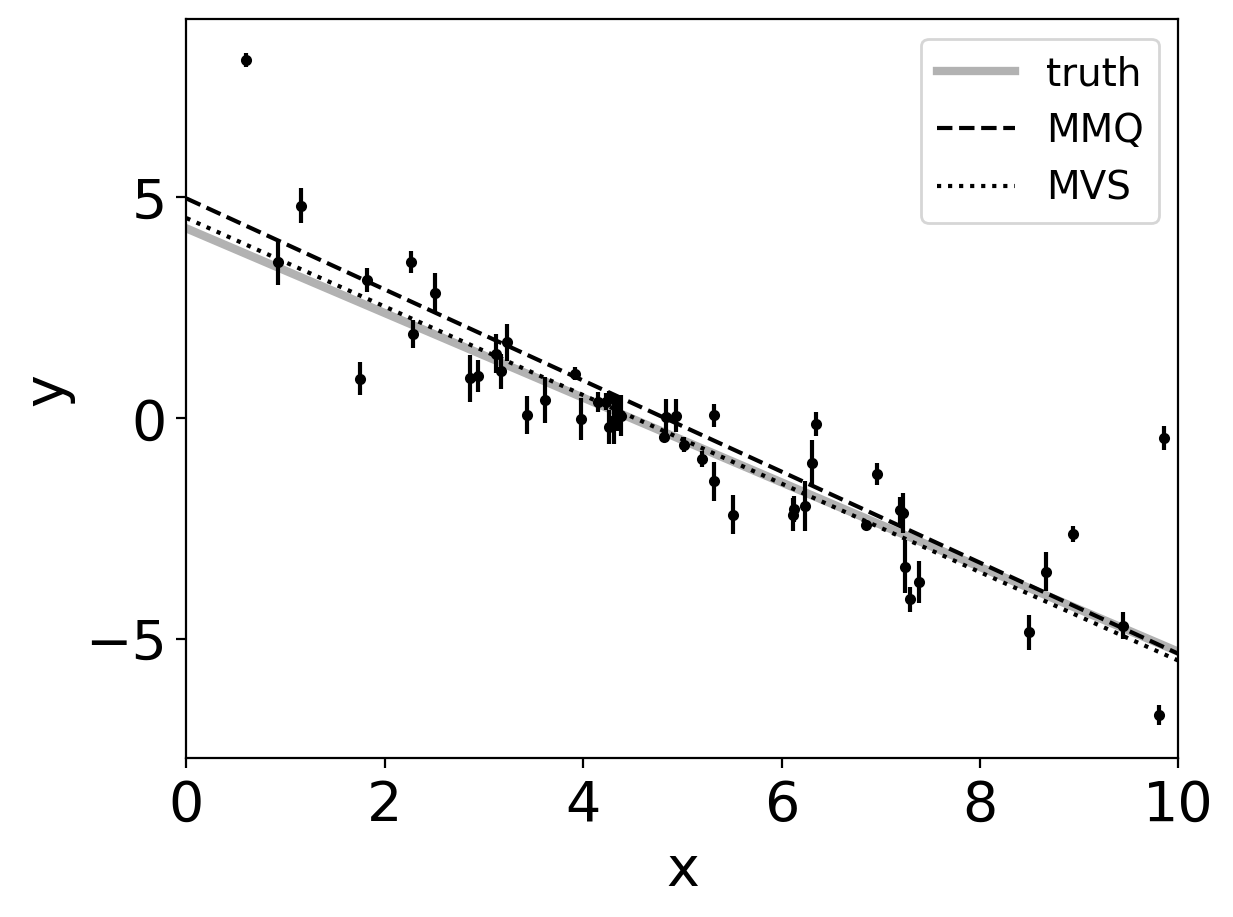

In [7]:
from scipy.optimize import minimize

np.random.seed(42)

nll = lambda *args: - log_likelihood(*args)

initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 *np.random.randn(3)
soln = minimize(nll, initial, args=(x,y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Máxima Verossimilhança")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="MMQ")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="MVS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")


Tomando a função prior:

$ p(m) = 1/5.5$ para $-5\leq m \leq 0.5$

In [8]:
def log_prior(theta): #pior seria a função de probabilidade para estimar os parâmetros?
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr): #Se sim, pq eu defini uma log probibilidade aqui?
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)



In [21]:
!pip install emcee #Rodar isso para ter certeza que instalou

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 444.4 kB/s eta 0:00:00a 0:00:01


In [9]:
import emcee

pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape #O que quer dizer esse método shape?

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)


100%|██████████| 5000/5000 [00:33<00:00, 149.48it/s]


State([[-1.16616948  5.24748614 -0.97736504]
 [-1.14231127  5.24489466 -0.88748902]
 [-0.95312818  4.30565067 -0.7887176 ]
 [-0.98349332  4.421649   -0.61744452]
 [-0.91954943  4.15531993 -0.72585123]
 [-0.98841696  4.47577417 -0.81777977]
 [-1.05548034  4.76012706 -0.83981677]
 [-0.8683339   4.0557452  -0.53167414]
 [-1.04469665  4.69106976 -0.61885288]
 [-0.98809147  4.44514798 -0.60130281]
 [-1.07243137  4.74127916 -0.79576435]
 [-0.91817866  4.08555982 -0.52444216]
 [-0.96082575  4.26328864 -0.71229701]
 [-0.88430636  4.03361603 -0.51860783]
 [-1.05429109  4.79871478 -0.80180301]
 [-0.93191562  4.20686596 -0.59972861]
 [-0.98736751  4.52436147 -0.7720333 ]
 [-0.93169446  4.22619955 -0.57773959]
 [-1.13353385  5.10929796 -0.63713189]
 [-1.03907186  4.64957005 -0.57049062]
 [-0.94616619  4.27641172 -0.6714083 ]
 [-1.0423278   4.63058329 -0.72244567]
 [-1.08988987  4.97379585 -0.92951618]
 [-0.72791984  3.33538319 -0.21355016]
 [-1.00806637  4.56430164 -0.97218299]
 [-1.03393316  4.69

Text(0.5, 0, 'step number')

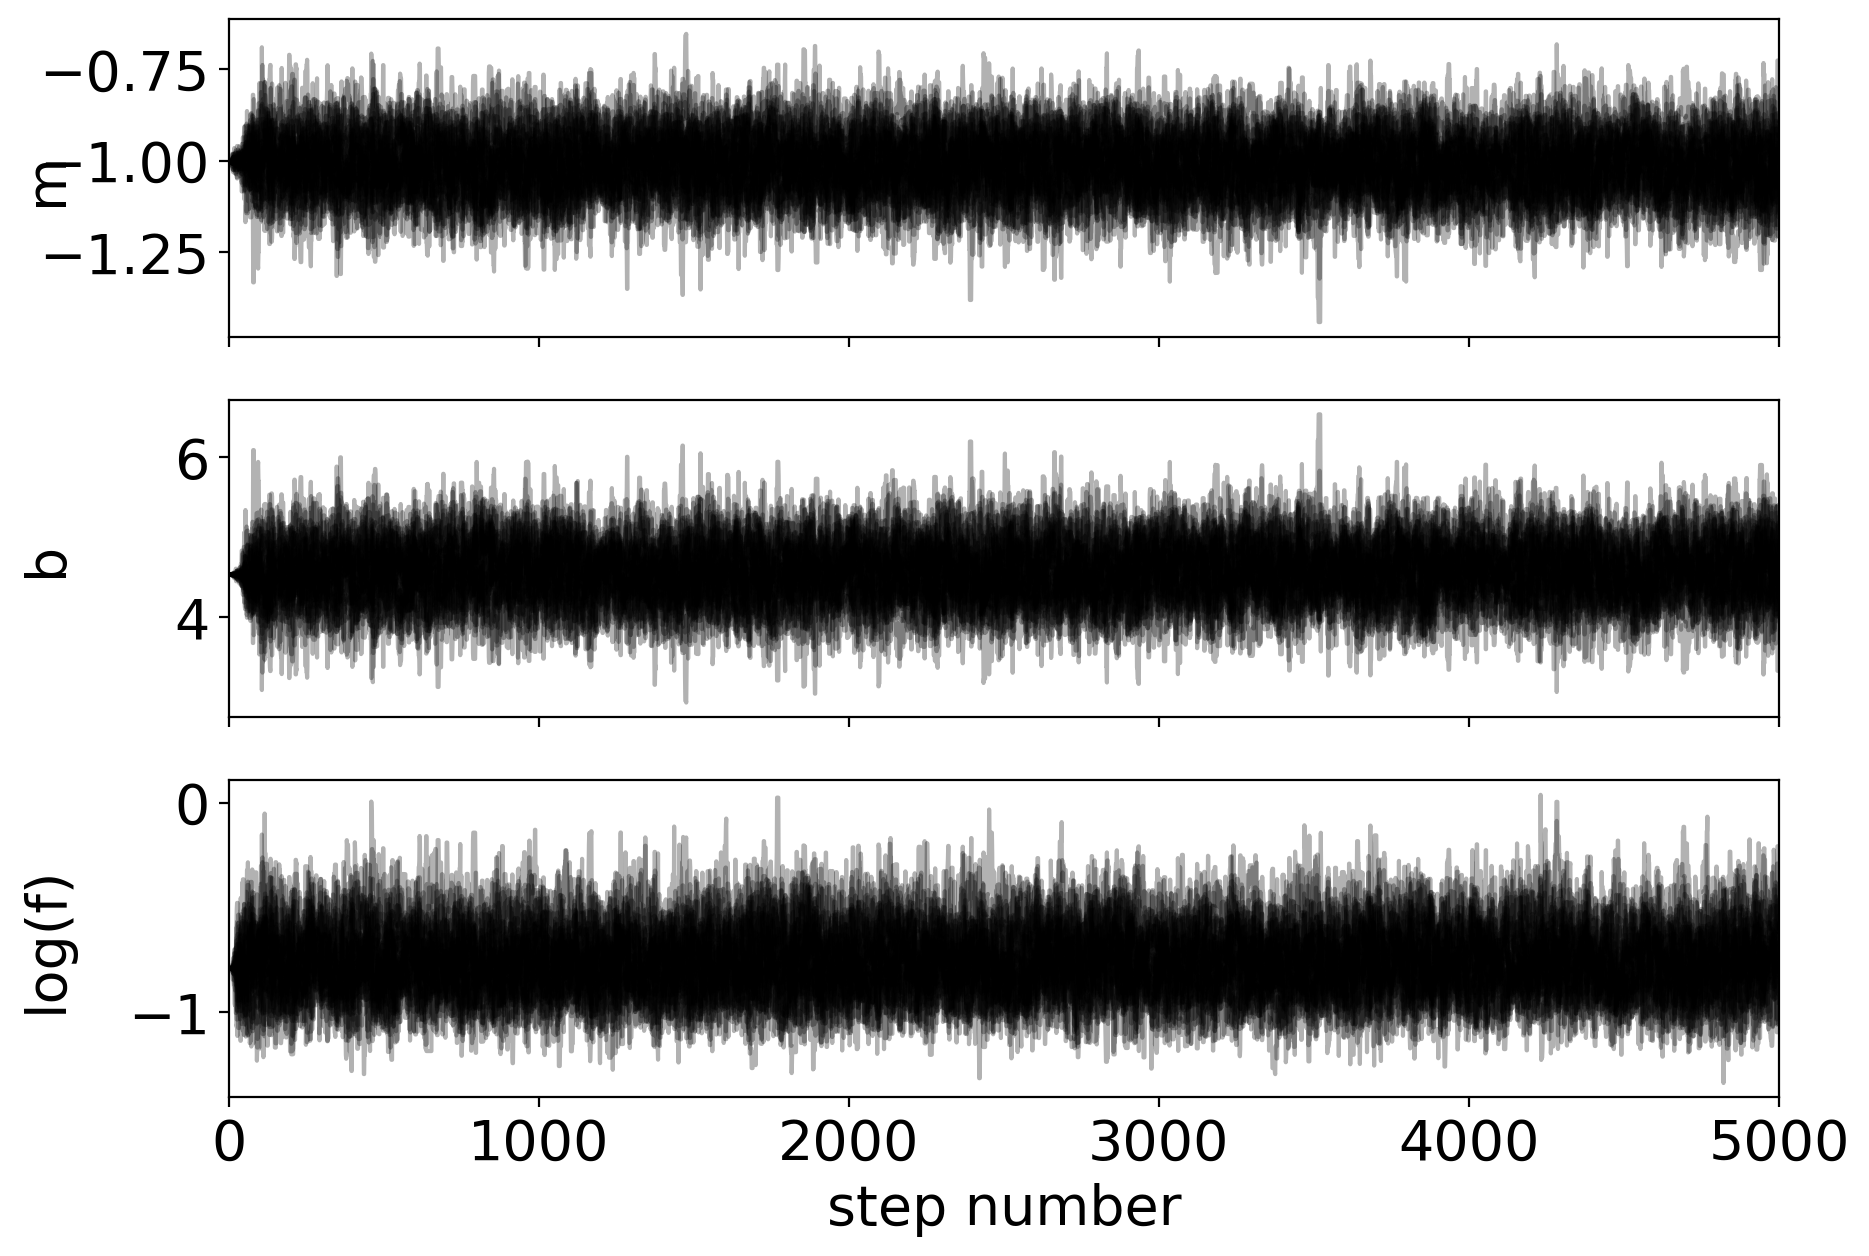

In [10]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [13]:
#Número de passos (ou amostras) para fazer o burn-in

tau = sampler.get_autocorr_time()
print(tau)

[36.03979862 35.45827512 37.02933472]


In [15]:
#Não peguei a necessidade desse passo. O que seriam "flat Samples"?

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


(10432, 3)


In [18]:
!pip install corner

Defaulting to user installation because normal site-packages is not writeable


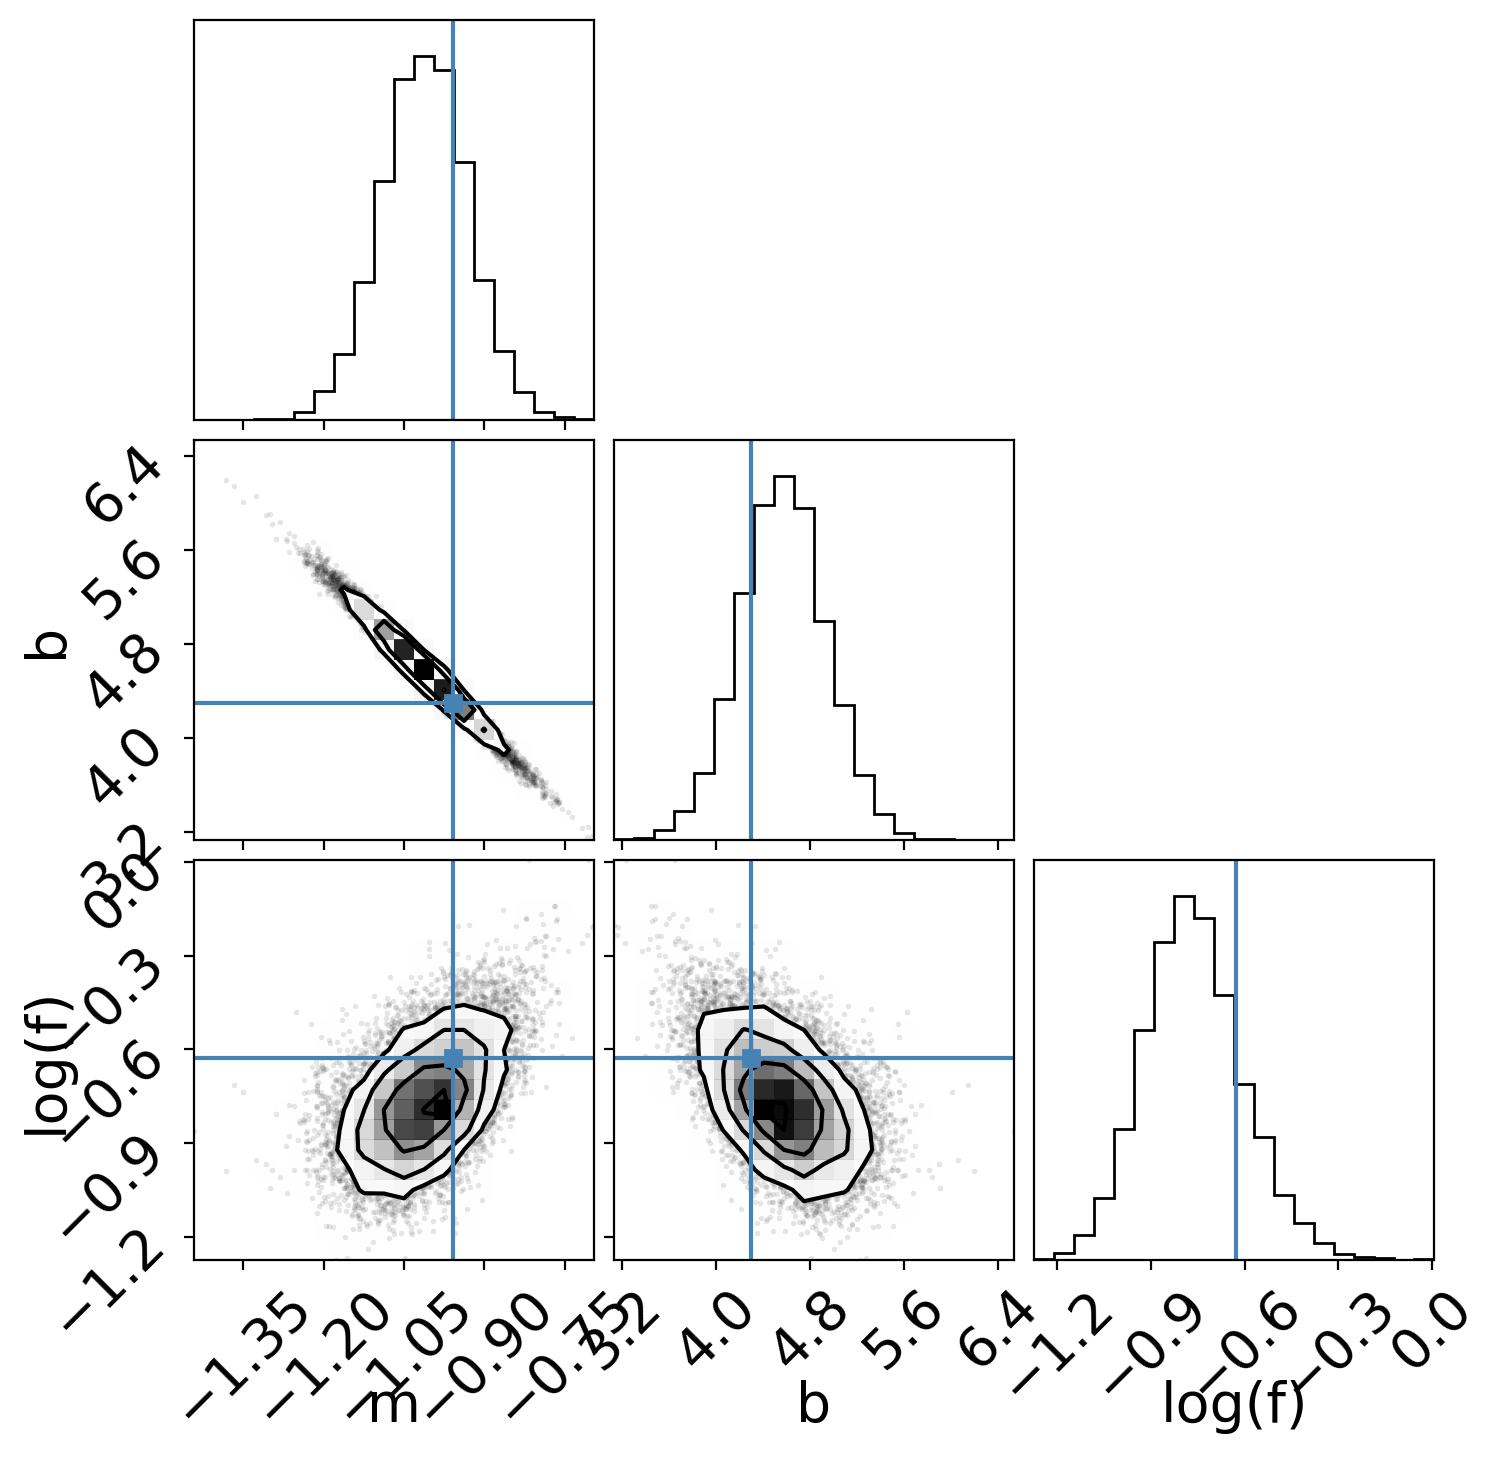

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)